In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp.graphs as graphs
import scipy.spatial.distance as distance
import sparsify
import pandas as pd

In [63]:
def torus_deterministic(R,r,N):
    def parameter_map(parameters):
        theta0 = parameters[0]
        theta1 = parameters[1]
        point = np.array([(R+r*np.cos(theta1))*np.cos(theta0),(R+r*np.cos(theta1))*np.sin(theta0),r*np.sin(theta1)])
        return point
    theta0_array = np.repeat(np.linspace(0,2*np.pi,round(np.sqrt(N))),round(np.sqrt(N))).reshape(-1,1)
    theta1_array = []
    for i in range(round(np.sqrt(N))):
        theta1_array.append(np.linspace(0,2*np.pi,round(np.sqrt(N))))
    theta1_array = np.array(theta1_array).reshape(-1,1)
    parameters_array = np.hstack((theta0_array,theta1_array))
    mapped_points = [parameter_map(pair) for pair in parameters_array]
    return np.array(mapped_points), parameters_array

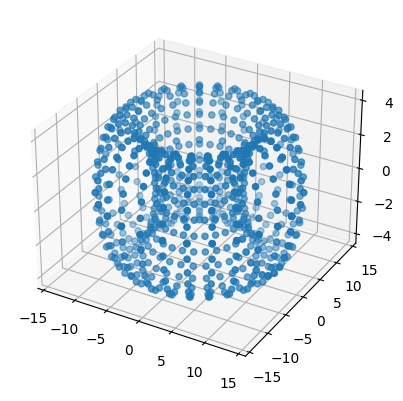

In [85]:
coords, _ = torus_deterministic(10,4,800)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(coords[:,0], coords[:,1], coords[:,2])

In [86]:
# calculate all pairwise distances
def calculate_distance_matrix(points):
    Dists = distance.squareform(distance.pdist(points))
    return Dists

def calculate_affinity_matrix(points):
    
    # Input : N points on the swiss roll
    # Output : an N X N anisotropic kernel 
    
    N = len(points)
    
    # calculate all pairwise distances
    
    Dists = calculate_distance_matrix(points)

    # get the average distance to the 10th nearest neighbor
    sigma = np.mean(np.sort(Dists,axis=0)[11])
    
    # the kernel function which 
    def kernel(x,sigma):
        return 1/np.sqrt(2*np.pi*sigma) * np.exp(-x**2/(2*(sigma**2)))
    
    # apply the kernel function appropriately 
    K = kernel(Dists,sigma) - (1/np.sqrt(2*np.pi*sigma)) * np.eye(N)
    
    # calculate the degrees and apply appropriately to create the kernel G
    Q = np.diag(K@np.ones(N)); Qinv = np.linalg.inv(Q)
    G = Qinv@K@Qinv
    
    return G

In [87]:
W = calculate_affinity_matrix(coords)
D = calculate_distance_matrix(coords)
P = np.diag(1/np.sum(W,axis=0))@W

In [92]:
G = graphs.Graph(W*(W>2e-3))
G.is_connected()

True

In [93]:
G = graphs.Graph(W*(W>2e-3))
s = sparsify.Sparsifier(G)

In [96]:
np.sum(1*(W>2e-3))

19268

In [94]:
s.sparsify_by_resistances()

100%|████████████████████████████████████| 19268/19268 [00:47<00:00, 403.31it/s]


In [127]:
s.q = 10000
s.Sample_Edges()
G_ = s.get_sparsifier()
W_sparse = np.array(W_sparse)

100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 335.30it/s]


In [129]:
P_ = np.diag(1/np.sum(W_sparse,axis=0))@W_sparse

In [130]:
def curvature(P,D,x,r,t):
    P_t = np.linalg.matrix_power(P,t)
    m_x = P_t[x,:]
    num = np.sum(m_x[D[x] < r])
    denom = np.sum(1*(D[x]<r))
    return num/denom

In [145]:
curvature(P,D,0,2,10)

0.004515866993482664

In [146]:
curvature(P_,D,0,2,10)

0.01269668084387089

In [133]:
all_baseline = [curvature(P,D,i,1e-1,2) for i in range(G.N)]

In [134]:
all_sparsified = [curvature(P_,D,i,1e-1,2) for i in range(G.N)]

In [147]:
from tqdm import tqdm

In [150]:
all_cors = []
for q in [10000, 20000, 30000]:
    s.q = q
    s.Sample_Edges()
    G_ = s.get_sparsifier()
    W_sparse = np.array(W_sparse)
    P_ = np.diag(1/np.sum(W_sparse,axis=0))@W_sparse
    
    cors = {}
    
    for r in range(5):
        all_baseline = [curvature(P,D,i,r,2) for i in range(G.N)]
        all_sparsified = [curvature(P_,D,i,r,2) for i in range(G.N)]
        
        cors[r] = np.corrcoef(all_baseline,all_sparsified)[0,1]
        
    all_cors.append(cors)

100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 372.48it/s]
/var/folders/vv/h1bxm3t15sx2m3r40_nzb0sr0000gn/T/ipykernel_45741/1623793555.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return num/denom
100%|████████████████████████████████████| 30000/30000 [01:25<00:00, 350.26it/s]


In [151]:
all_cors

[{0: nan,
  1: -0.28156989150132816,
  2: 0.3122753659542702,
  3: 0.5530889640129492,
  4: 0.6596184795931684},
 {0: nan,
  1: -0.28156989150132816,
  2: 0.3122753659542702,
  3: 0.5530889640129492,
  4: 0.6596184795931684},
 {0: nan,
  1: -0.28156989150132816,
  2: 0.3122753659542702,
  3: 0.5530889640129492,
  4: 0.6596184795931684}]

In [161]:
all_cors2 = []
for q in [10000, 20000, 30000]:
    s.q = q
    s.Sample_Edges()
    G_ = s.get_sparsifier()
    W_sparse = G_.W.todense()
    W_sparse = np.array(W_sparse)
    P_ = np.diag(1/np.sum(W_sparse,axis=0))@W_sparse
    
    cors = {}
    
    for r in range(1,6):
        all_baseline = [curvature(P,D,i,r,2) for i in range(G.N)]
        all_sparsified = [curvature(P_,D,i,r,2) for i in range(G.N)]
        cors[r] = np.corrcoef(all_baseline,all_sparsified)[0,1]
        print(cors)
        
    all_cors2.append(cors)

100%|████████████████████████████████████| 10000/10000 [00:27<00:00, 364.09it/s]


{1: -0.42458559383548417}
{1: -0.42458559383548417, 2: 0.25031153472676015}
{1: -0.42458559383548417, 2: 0.25031153472676015, 3: 0.6050434126306442}
{1: -0.42458559383548417, 2: 0.25031153472676015, 3: 0.6050434126306442, 4: 0.7338044710096702}
{1: -0.42458559383548417, 2: 0.25031153472676015, 3: 0.6050434126306442, 4: 0.7338044710096702, 5: 0.9469516523449593}


100%|████████████████████████████████████| 20000/20000 [00:51<00:00, 385.68it/s]


{1: -0.5398396261079336}
{1: -0.5398396261079336, 2: 0.020530662664890134}
{1: -0.5398396261079336, 2: 0.020530662664890134, 3: 0.5339155214645723}
{1: -0.5398396261079336, 2: 0.020530662664890134, 3: 0.5339155214645723, 4: 0.7570686360306866}
{1: -0.5398396261079336, 2: 0.020530662664890134, 3: 0.5339155214645723, 4: 0.7570686360306866, 5: 0.9650168326919395}


100%|████████████████████████████████████| 30000/30000 [01:26<00:00, 346.25it/s]


{1: -0.5596051626479781}
{1: -0.5596051626479781, 2: 0.027042093057827715}
{1: -0.5596051626479781, 2: 0.027042093057827715, 3: 0.5700319244115972}
{1: -0.5596051626479781, 2: 0.027042093057827715, 3: 0.5700319244115972, 4: 0.7985180250808199}
{1: -0.5596051626479781, 2: 0.027042093057827715, 3: 0.5700319244115972, 4: 0.7985180250808199, 5: 0.9746941107811489}


In [170]:
df = pd.DataFrame(all_cors2)

In [171]:
df.index = [10000,20000,30000]

In [172]:
df.head()

,1,2,3,4,5
10000,-0.424586,0.250312,0.605043,0.733804,0.946952
20000,-0.539840,0.020531,0.533916,0.757069,0.965017
30000,-0.559605,0.027042,0.570032,0.798518,0.974694
